## Refinement of initial results using an outer loop

Plan:

ACASXU
- Look into ensemble nature of acas xu
- Distill a trained network
    - data-free distillation
    - QMC method?
- If distilled network does not match closeness property, keep distilling
- If distilled network failed safety property, use counterexample as a new data point.
- If both teacher and student network fail safety property, enforce it?

Others
- Images / CNN, can I detect the heirarchical split between layers? Is that caused by architecture restriction of the covariates (eg, convolution kernel)
- XOR network, can I show that training on big network is more efficient than training on small network?


Decisions:
- Synthetic dataset generated once for all training, or is it re-generated at each epoch?
- Choice in neural network (ACAS vs XOR)
- Sampling technique (QMC, IID, Inception)
- Training parameters including asymmetric loss functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import onnx
import onnx_tf
import onnxruntime

rng = np.random.default_rng()

In [1]:
## Teacher Networks
acas_xu_teacher = onnx.load("/Users/jperrsau/cu-src/thesis/src/nnenum/examples/acasxu/data/ACASXU_run2a_1_1_batch_2000.onnx")
acas_xu_teacher = onnx_tf.backend.prepare(acas_xu_teacher)
## Example usage of this object:
# inputs = (rng.random((2000,1,1,5),dtype="float32")-0.5)*2
# onnx_outputs = acas_xu.run(inputs)
# outputs = onnx_outputs.linear_7_Add

NameError: name 'onnx' is not defined

In [3]:
synthetic_inputs = (rng.random((2000,1,1,5),dtype="float32")-0.5)*2
onnx_outputs = acas_xu_teacher.run(synthetic_inputs)
synthetic_inputs = synthetic_inputs.reshape((2000,5))
synthetic_outputs = onnx_outputs.linear_7_Add

hidden_layer_width=200
num_hidden_layers=2

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(5,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(5))

student_model = tf.keras.Sequential(layers)

student_model.summary()

## Julian K uses an asymmetric loss function based on MSE. We use MSE here for now.

student_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    #loss=tf.keras.losses.KLDivergence(),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    optimizer=tf.keras.optimizers.Adam(0.001)
)

student_model.fit(
    x=synthetic_inputs,
    y=synthetic_outputs,#synthetic_outputs, #- Using logits in the loss function requires a different loss metric, like KLDivergence. But I couldn't get it working immediately.
    epochs=500,
    batch_size=128,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    ]
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1200      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 42,405
Trainable params: 42,405
Non-trainable params: 0
_________________________________________________________________


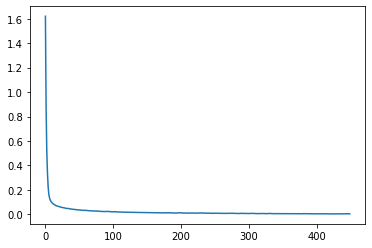

In [9]:
plt.plot(student_model.history.history['loss'])

In [ ]:
while True:
    counterexamples = []